<a href="https://colab.research.google.com/github/f8sle/report/blob/main/11%EC%A3%BC%EC%B0%A8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iter : 0
Train Loss : 3.3491, Train Accuracy : 0.0600
Test Loss : 3.2827, Test Accuracy : 0.0600
Iter : 250
Train Loss : 0.2033, Train Accuracy : 0.9800
Test Loss : 0.3737, Test Accuracy : 0.8600
Iter : 500
Train Loss : 0.1928, Train Accuracy : 0.9400
Test Loss : 0.2224, Test Accuracy : 0.9000
Iter : 750
Train Loss : 0.2096, Train Accuracy : 0.9200
Test Loss : 0.1400, Test Accuracy : 0.9600
Iter : 1000
Train Loss : 0.0526, Train Accuracy : 0.9800
Test Loss : 0.0820, Test Accuracy : 0.9800
Iter : 1250
Train Loss : 0.1698, Train Accuracy : 0.9400
Test Loss : 0.0721, Test Accuracy : 0.9800
Iter : 1500
Train Loss : 0.1110, Train Accuracy : 0.9400
Test Loss : 0.1478, Test Accuracy : 0.9400
Iter : 1750
Train Loss : 0.1092, Train Accuracy : 0.9600
Test Loss : 0.0443, Test Accuracy : 0.9800
Iter : 2000
Train Loss : 0.1660, Train Accuracy : 0.9600
Test Loss : 0.1560, Test Accuracy : 0.9800
Iter : 2250
Train Loss : 0.0333, Train Accuracy : 0.9800
Test Loss : 0.0487, Test Accuracy : 0.9800

Final

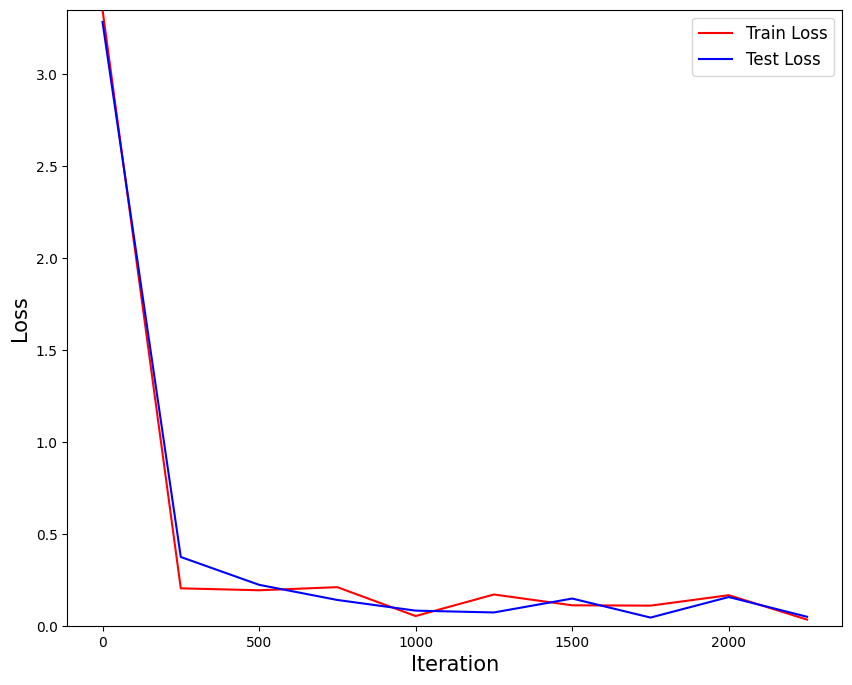

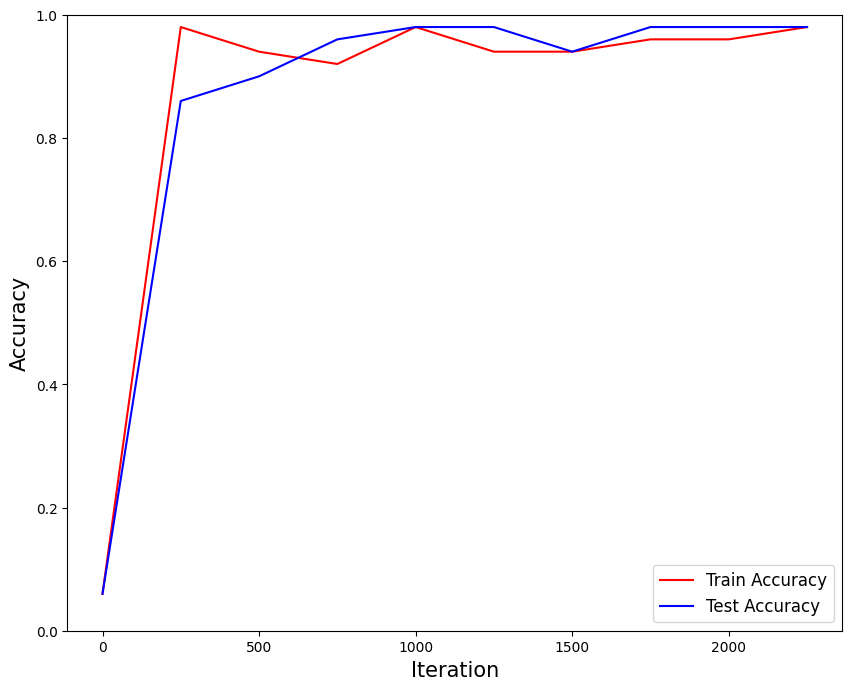

In [9]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt

tf.disable_v2_behavior()

# Load and preprocess data
mnist = tf.keras.datasets.mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x, test_x = train_x/255.0, test_x/255.0
train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

# Convert labels to one-hot
train_y = tf.keras.utils.to_categorical(train_y, 10)
test_y = tf.keras.utils.to_categorical(test_y, 10)

# Input layer
input_h = 28    # input height
input_w = 28    # input width
input_ch = 1    # input channel: Gray scale

# 1st convolution layer
k1_h = 5        # kernel height
k1_w = 5        # kernel width
k1_ch = 32      # output channels
p1_h = 2        # pool height
p1_w = 2        # pool width
# Output: (None, 14, 14, 32) after max pooling

# 2nd convolution layer
k2_h = 5        # kernel height
k2_w = 5        # kernel width
k2_ch = 64      # output channels
p2_h = 2        # pool height
p2_w = 2        # pool width
# Output: (None, 7, 7, 64) after max pooling

# Fully connected
conv_result_size = 7 * 7 * 64  # After second max pooling
n_hidden = 100                 # Hidden layer neurons
n_output = 10                  # Number of classes (0-9)

# Weights
weights = {
    'conv1': tf.Variable(tf.random.normal([k1_h, k1_w, input_ch, k1_ch], stddev=0.1)),
    'conv2': tf.Variable(tf.random.normal([k2_h, k2_w, k1_ch, k2_ch], stddev=0.1)),
    'hidden': tf.Variable(tf.random.normal([conv_result_size, n_hidden], stddev=0.1)),
    'output': tf.Variable(tf.random.normal([n_hidden, n_output], stddev=0.1))
}

# Biases
biases = {
    'conv1': tf.Variable(tf.random.normal([k1_ch], stddev=0.1)),
    'conv2': tf.Variable(tf.random.normal([k2_ch], stddev=0.1)),
    'hidden': tf.Variable(tf.random.normal([n_hidden], stddev=0.1)),
    'output': tf.Variable(tf.random.normal([n_output], stddev=0.1))
}

# Placeholders
x = tf.placeholder(shape=[None, input_h, input_w, input_ch], dtype=tf.float32)
y = tf.placeholder(shape=[None, n_output], dtype=tf.float32)

def net(x, weights, biases):
    # 1st convolution layer
    conv1 = tf.nn.conv2d(x, weights['conv1'], strides=[1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))
    maxp1 = tf.nn.max_pool(conv1, ksize=[1, p1_h, p1_w, 1], strides=[1, p1_h, p1_w, 1], padding='VALID')

    # 2nd convolution layer
    conv2 = tf.nn.conv2d(maxp1, weights['conv2'], strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))
    maxp2 = tf.nn.max_pool(conv2, ksize=[1, p2_h, p2_w, 1], strides=[1, p2_h, p2_w, 1], padding='VALID')

    # Flatten
    maxp2_flatten = tf.reshape(maxp2, [-1, conv_result_size])

    # Fully connected
    hidden = tf.add(tf.matmul(maxp2_flatten, weights['hidden']), biases['hidden'])
    hidden = tf.nn.relu(hidden)
    output = tf.add(tf.matmul(hidden, weights['output']), biases['output'])

    return output

# Model
LR = 0.0001
pred = net(x, weights, biases)
loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)
loss = tf.reduce_mean(loss)
optm = tf.train.AdamOptimizer(learning_rate=LR).minimize(loss)

# Evaluation metrics
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Training
n_batch = 50
n_iter = 2500
n_prt = 250

sess = tf.Session()
sess.run(tf.global_variables_initializer())

loss_record_train = []
loss_record_test = []
acc_record_train = []
acc_record_test = []

for epoch in range(n_iter):
    # Get batch
    batch_indices = np.random.choice(train_x.shape[0], n_batch)
    batch_x = train_x[batch_indices]
    batch_y = train_y[batch_indices]

    sess.run(optm, feed_dict={x: batch_x, y: batch_y})

    if epoch % n_prt == 0:
        # Test batch
        test_indices = np.random.choice(test_x.shape[0], n_batch)
        batch_test_x = test_x[test_indices]
        batch_test_y = test_y[test_indices]

        # Compute loss and accuracy
        c1, a1 = sess.run([loss, accuracy], feed_dict={x: batch_x, y: batch_y})
        c2, a2 = sess.run([loss, accuracy], feed_dict={x: batch_test_x, y: batch_test_y})

        loss_record_train.append(c1)
        loss_record_test.append(c2)
        acc_record_train.append(a1)
        acc_record_test.append(a2)

        print("Iter : {}".format(epoch))
        print("Train Loss : {:.4f}, Train Accuracy : {:.4f}".format(c1, a1))
        print("Test Loss : {:.4f}, Test Accuracy : {:.4f}".format(c2, a2))

# Final evaluation on full test set
test_accuracy = sess.run(accuracy, feed_dict={x: test_x, y: test_y})
print("\nFinal Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting losses
plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(loss_record_train)) * n_prt, loss_record_train, 'r', label='Train Loss')
plt.plot(np.arange(len(loss_record_test)) * n_prt, loss_record_test, 'b', label='Test Loss')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0, max(max(loss_record_train), max(loss_record_test))])
plt.savefig('loss_plot.png')

# Plotting accuracies
plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(acc_record_train)) * n_prt, acc_record_train, 'r', label='Train Accuracy')
plt.plot(np.arange(len(acc_record_test)) * n_prt, acc_record_test, 'b', label='Test Accuracy')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0, 1])
plt.savefig('accuracy_plot.png')

Iter : 0
Train Loss : 3.8323, Train Accuracy : 0.0600
Test Loss : 3.9061, Test Accuracy : 0.1000
Iter : 250
Train Loss : 0.2932, Train Accuracy : 0.9200
Test Loss : 0.3961, Test Accuracy : 0.8600
Iter : 500
Train Loss : 0.0762, Train Accuracy : 1.0000
Test Loss : 0.3466, Test Accuracy : 0.9000
Iter : 750
Train Loss : 0.0744, Train Accuracy : 0.9800
Test Loss : 0.3044, Test Accuracy : 0.8800
Iter : 1000
Train Loss : 0.1322, Train Accuracy : 0.9400
Test Loss : 0.0429, Test Accuracy : 1.0000
Iter : 1250
Train Loss : 0.0709, Train Accuracy : 0.9800
Test Loss : 0.0258, Test Accuracy : 1.0000
Iter : 1500
Train Loss : 0.0347, Train Accuracy : 0.9800
Test Loss : 0.0536, Test Accuracy : 0.9800
Iter : 1750
Train Loss : 0.0625, Train Accuracy : 0.9800
Test Loss : 0.1065, Test Accuracy : 0.9400
Iter : 2000
Train Loss : 0.0186, Train Accuracy : 1.0000
Test Loss : 0.0121, Test Accuracy : 1.0000
Iter : 2250
Train Loss : 0.2300, Train Accuracy : 0.9600
Test Loss : 0.0115, Test Accuracy : 1.0000

Final

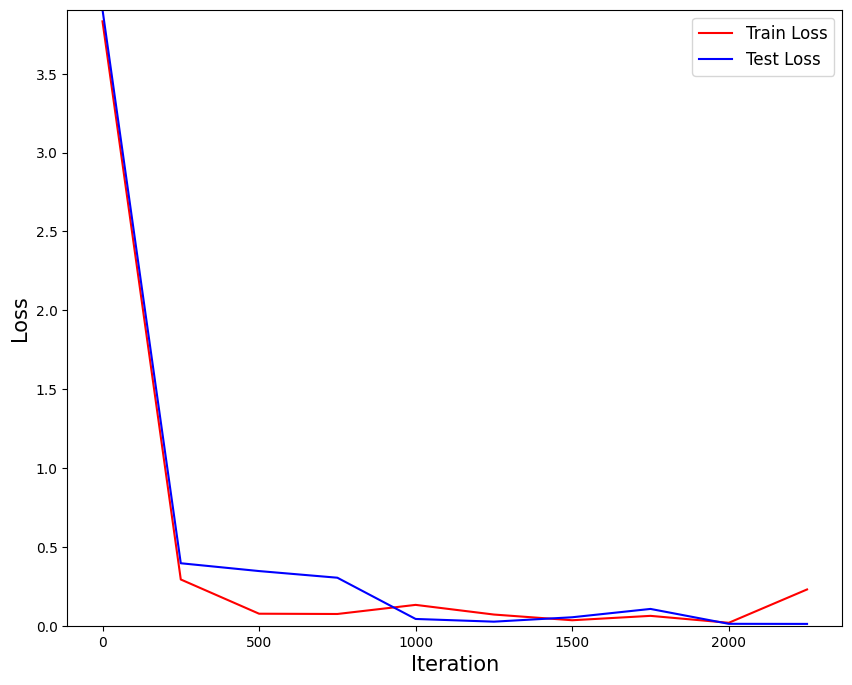

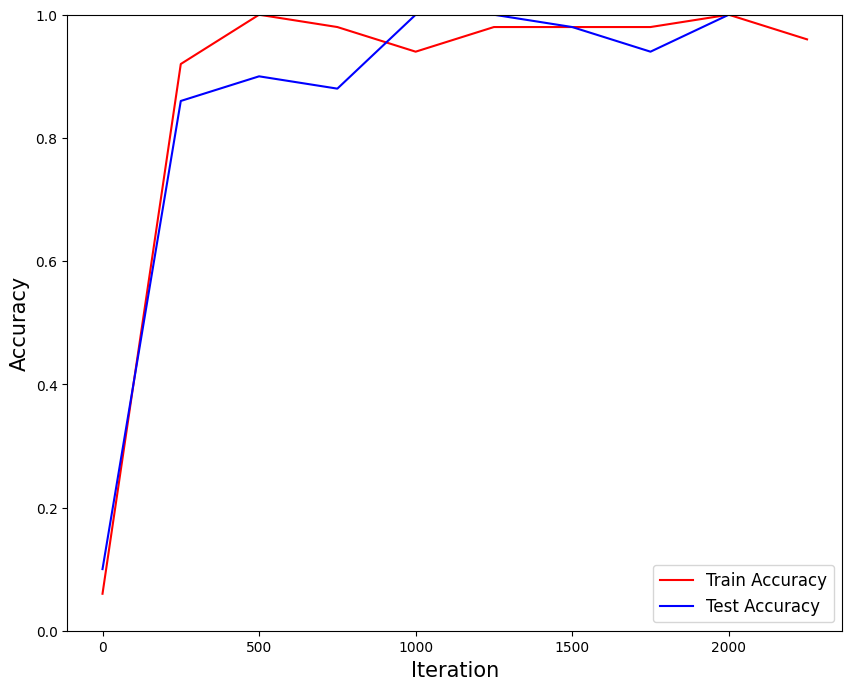

In [8]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt

tf.disable_v2_behavior()

# Load and preprocess data
mnist = tf.keras.datasets.mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x, test_x = train_x/255.0, test_x/255.0
train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

# Convert labels to one-hot
train_y = tf.keras.utils.to_categorical(train_y, 10)
test_y = tf.keras.utils.to_categorical(test_y, 10)

# Input layer
input_h = 28    # input height
input_w = 28    # input width
input_ch = 1    # input channel: Gray scale

# 1st convolution layer
k1_h = 5        # kernel height
k1_w = 5        # kernel width
k1_ch = 32      # output channels
p1_h = 2        # pool height
p1_w = 2        # pool width
# Output: (None, 14, 14, 32) after max pooling

# 2nd convolution layer
k2_h = 5        # kernel height
k2_w = 5        # kernel width
k2_ch = 64      # output channels
p2_h = 2        # pool height
p2_w = 2        # pool width
# Output: (None, 7, 7, 64) after max pooling

# 3rd convolution layer
k3_h = 3        # kernel height
k3_w = 3        # kernel width
k3_ch = 128     # output channels
p3_h = 2        # pool height
p3_w = 2        # pool width
# Output: (None, 3, 3, 128) after max pooling

# Fully connected
conv_result_size = 3 * 3 * 128  # After third max pooling
n_fully_connected1 = 100        # First fully connected layer neurons
n_fully_connected2 = 256        # Second fully connected layer neurons
n_output = 10                   # Number of classes (0-9)

# Weights
weights = {
    'conv1': tf.Variable(tf.random.normal([k1_h, k1_w, input_ch, k1_ch], stddev=0.1)),
    'conv2': tf.Variable(tf.random.normal([k2_h, k2_w, k1_ch, k2_ch], stddev=0.1)),
    'conv3': tf.Variable(tf.random.normal([k3_h, k3_w, k2_ch, k3_ch], stddev=0.1)),
    'fully_connected1': tf.Variable(tf.random.normal([conv_result_size, n_fully_connected1], stddev=0.1)),
    'fully_connected2': tf.Variable(tf.random.normal([n_fully_connected1, n_fully_connected2], stddev=0.1)),
    'output': tf.Variable(tf.random.normal([n_fully_connected2, n_output], stddev=0.1))
}

# Biases
biases = {
    'conv1': tf.Variable(tf.random.normal([k1_ch], stddev=0.1)),
    'conv2': tf.Variable(tf.random.normal([k2_ch], stddev=0.1)),
    'conv3': tf.Variable(tf.random.normal([k3_ch], stddev=0.1)),
    'fully_connected1': tf.Variable(tf.random.normal([n_fully_connected1], stddev=0.1)),
    'fully_connected2': tf.Variable(tf.random.normal([n_fully_connected2], stddev=0.1)),
    'output': tf.Variable(tf.random.normal([n_output], stddev=0.1))
}

# Placeholders
x = tf.placeholder(shape=[None, input_h, input_w, input_ch], dtype=tf.float32)
y = tf.placeholder(shape=[None, n_output], dtype=tf.float32)

def net(x, weights, biases):
    # 1st convolution layer
    conv1 = tf.nn.conv2d(x, weights['conv1'], strides=[1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))
    maxp1 = tf.nn.max_pool(conv1, ksize=[1, p1_h, p1_w, 1], strides=[1, p1_h, p1_w, 1], padding='VALID')

    # 2nd convolution layer
    conv2 = tf.nn.conv2d(maxp1, weights['conv2'], strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))
    maxp2 = tf.nn.max_pool(conv2, ksize=[1, p2_h, p2_w, 1], strides=[1, p2_h, p2_w, 1], padding='VALID')

    # 3rd convolution layer
    conv3 = tf.nn.conv2d(maxp2, weights['conv3'], strides=[1, 1, 1, 1], padding='SAME')
    conv3 = tf.nn.relu(tf.add(conv3, biases['conv3']))
    maxp3 = tf.nn.max_pool(conv3, ksize=[1, p3_h, p3_w, 1], strides=[1, p3_h, p3_w, 1], padding='VALID')

    # Flatten
    maxp3_flatten = tf.reshape(maxp3, [-1, conv_result_size])

    # Fully connected layers
    fully_connected1 = tf.add(tf.matmul(maxp3_flatten, weights['fully_connected1']), biases['fully_connected1'])
    fully_connected1 = tf.nn.relu(fully_connected1)
    fully_connected2 = tf.add(tf.matmul(fully_connected1, weights['fully_connected2']), biases['fully_connected2'])
    fully_connected2 = tf.nn.relu(fully_connected2)
    output = tf.add(tf.matmul(fully_connected2, weights['output']), biases['output'])

    return output

# Model
LR = 0.0001
pred = net(x, weights, biases)
loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)
loss = tf.reduce_mean(loss)
optm = tf.train.AdamOptimizer(learning_rate=LR).minimize(loss)

# Evaluation metrics
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Training
n_batch = 50
n_iter = 2500
n_prt = 250

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    loss_record_train = []
    loss_record_test = []
    acc_record_train = []
    acc_record_test = []

    # Create shuffled indices for training
    n_samples = train_x.shape[0]
    indices = np.arange(n_samples)

    for epoch in range(n_iter):
        # Shuffle indices for each epoch
        np.random.shuffle(indices)
        batch_indices = indices[:n_batch]
        batch_x = train_x[batch_indices]
        batch_y = train_y[batch_indices]

        sess.run(optm, feed_dict={x: batch_x, y: batch_y})

        if epoch % n_prt == 0:
            # Test batch
            test_indices = np.random.choice(test_x.shape[0], n_batch)
            batch_test_x = test_x[test_indices]
            batch_test_y = test_y[test_indices]

            # Compute loss and accuracy
            c1, a1 = sess.run([loss, accuracy], feed_dict={x: batch_x, y: batch_y})
            c2, a2 = sess.run([loss, accuracy], feed_dict={x: batch_test_x, y: batch_test_y})

            loss_record_train.append(c1)
            loss_record_test.append(c2)
            acc_record_train.append(a1)
            acc_record_test.append(a2)

            print("Iter : {}".format(epoch))
            print("Train Loss : {:.4f}, Train Accuracy : {:.4f}".format(c1, a1))
            print("Test Loss : {:.4f}, Test Accuracy : {:.4f}".format(c2, a2))

    # Final evaluation on full test set
    test_accuracy = sess.run(accuracy, feed_dict={x: test_x, y: test_y})
    print("\nFinal Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting losses
plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(loss_record_train)) * n_prt, loss_record_train, 'r', label='Train Loss')
plt.plot(np.arange(len(loss_record_test)) * n_prt, loss_record_test, 'b', label='Test Loss')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0, max(max(loss_record_train), max(loss_record_test))])
plt.savefig('loss_plot.png')
plt.show()  # Display the plot
plt.close()

# Plotting accuracies
plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(acc_record_train)) * n_prt, acc_record_train, 'r', label='Train Accuracy')
plt.plot(np.arange(len(acc_record_test)) * n_prt, acc_record_test, 'b', label='Test Accuracy')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0, 1])
plt.savefig('accuracy_plot.png')
plt.show()  # Display the plot
plt.close()